In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from itertools import product
from tqdm.notebook import tqdm

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.special import binom
from scipy.stats import uniform

from tick.base import TimeFunction

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson

In [2]:
mpl.rcParams["figure.figsize"] = (15,8)
plt.style.use("bmh")

In [3]:
def get_bin_counts(sample):
    bin_counts = pd.DataFrame(sample['bin_j'].value_counts()).sort_index()
    return bin_counts

# Continuous

We have an assumed nonhomogeneous Poisson Process with polynomial intensity function as follows:

$ 
\lambda(t) = \theta_0 + \theta_1t + \theta_2t^2 + \theta_3t^3 + ...
$

For continuous time observations, log likelihood is of form:

$ 
l(\theta_0, \theta_1, \theta_2, ...; t_1, t_2, ..., t_n) = \sum_{i=1}^n \log(\theta_0 + \theta_1t_i + \theta_2t_i^2 + ...) - (\theta_0T + \frac{\theta_1T^2}{2} + \frac{\theta_2T^3}{3} + ...)
$

Jacobian is of form:

\begin{equation*}
    \begin{aligned}
        \frac{\partial l}{\partial \theta_0} &= \sum_{i=1}^n \frac{1}{\lambda(t_i)} - T \\
        \frac{\partial l}{\partial \theta_1} &= \sum_{i=1}^n \frac{t_i}{\lambda(t_i)} - \frac{T^2}{2} \\
        \frac{\partial l}{\partial \theta_2} &= \sum_{i=1}^n \frac{t_i^2}{\lambda(t_i)} - \frac{T^3}{3} \\
        ... \\
        \frac{\partial l}{\partial \theta_d} &= \sum_{i=1}^n \frac{t_i^d}{\lambda(t_i)} - \frac{T^{d + 1}}{d + 1}
    \end{aligned}
\end{equation*}

In [4]:
def lambda_t(timestamps, coeffs):
    """
    Calculates lambda(t) = x0 + x1t + x2t^2 + x3t^3 + ... for all provided values of t.
    coeffs is list-like with exponent keys, coefficient values
    e.g. coeffs = [] would be for 3t + 5t^3 + 6t^4, this is then multiplied by the
    value of t for each given time point. 
    Returned array is of same dimension as provided times array, it is the intensity at each time point.
    """
    return np.sum(
        [coeff * timestamps**power for power, coeff in enumerate(coeffs)],
        axis=0
    )


def T_integral(coeffs, T):
    """
    Calculates integral from 0 to T of x0 + x1*t + x2*t^2 + x3*t^3 ...
    """
    return np.sum([coeffs[power]/(power+1) * T**(power+1) for power, coeff in enumerate(coeffs)])


def log_likeli(coeffs, timestamps, T):
    """
    Evaluates log-likelihood for observed timestamps over period T, given polynomial coefficients.
    log likelihood is of form sum(log(x0 + x1*b*t_i + x2*c*t_i^2 + ...)) - (x0*T + x1 * T^2/2 + x2* T^3/3 + ...)
    """
    return np.sum(
        np.log(lambda_t(timestamps, coeffs))
    ) - T_integral(coeffs, T)


def jacobian(coeffs, timestamps, T):
    l_t = lambda_t(timestamps, coeffs)
    ts_powers = np.array([timestamps**power for power, coeff in enumerate(coeffs)])
    
    jacobian = (
        np.sum(ts_powers / l_t, axis=1)
        - np.array([T ** (power + 1) / (power + 1) for power, coeff in enumerate(coeffs)])
    )
    
    return jacobian


def hessian(coeffs, timestamps, T):
    lambda_t_squared = lambda_t(timestamps, coeffs) ** 2
    ts_powers = np.array([timestamps**power for power in range(2*len(coeffs) - 1)])
    hessian_vals = -np.sum(ts_powers / lambda_t_squared, axis=1)
    
    hessian = np.zeros((len(coeffs), len(coeffs)))
    for i in range(len(coeffs)):
        for j in range(len(coeffs)):
            hessian[i, j] = hessian_vals[i+j]
    
    return hessian


def get_mle(timestamps, T, init_params, bounds=None, method=None):
    mle = minimize(
        fun=lambda params: -log_likeli(params, timestamps, T), x0=init_params, method=method,
        jac=lambda params: -jacobian(params, timestamps, T),
        hess=lambda params: -hessian(params, timestamps, T),
        bounds=bounds
    )
    return mle

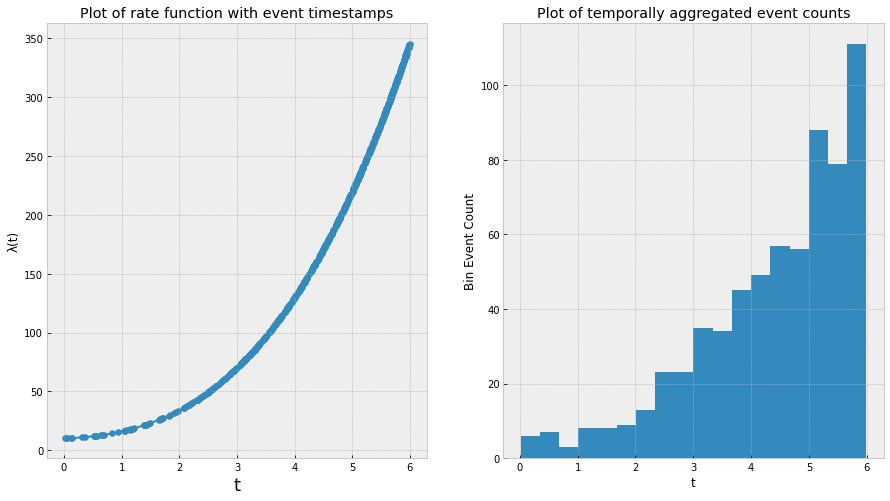

In [113]:
coeffs = np.array([10, 2, 3, 1]) # lambda(t) = a + bt + ct^2 + dt^3 + ...
poly_degree = len(coeffs) - 1
T = 6 # length of observations
N = 18 # number of bins
delta = T/N

t = np.linspace(0, T)
Y = lambda_t(t, coeffs)

tf = TimeFunction((t, Y))

# We define NHPP with the intensity function above
in_poi = SimuInhomogeneousPoisson([tf], end_time=T, verbose=False)
# We activate intensity tracking and launch simulation
in_poi.track_intensity(0.1)
in_poi.simulate()

# We plot the resulting inhomogeneous Poisson process with its
# intensity and its ticks over time

timestamps = in_poi.timestamps[0]
sample = pd.DataFrame(timestamps, columns=['t'])
sample['bin_j'] = sample['t'].apply(lambda x: int(np.floor((x/delta))))
bin_counts = get_bin_counts(sample)

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_point_process(in_poi, ax=ax1)
ax1.set_title('Plot of rate function with event timestamps')
ax1.set_xlabel('t')
ax1.set_ylabel('λ(t)')
ax2.hist(timestamps, bins=N)
ax2.set_title('Plot of temporally aggregated event counts')
ax2.set_xlabel('t')
ax2.set_ylabel('Bin Event Count')
plt.savefig("./thesis/nhpp_polynomial.pdf")

In [99]:
init_params = [1 for i in range(poly_degree+1)]

mle_params = get_mle(timestamps, T, init_params)
mle_params.x

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


array([12.48467788,  0.06054422,  3.70785136,  0.95687023])

In [100]:
log_likeli(mle_params.x, timestamps, T)

20416.75174544857

In [101]:
log_likeli(coeffs, timestamps, T)

20416.189128878766

## Binned

For binned-data with N $\Delta$-width bins (with associated counts $n_0, n_1, ..., n_{N-1}$), log-likelihood is of form:

$l(\theta_0, \theta_1, \theta_2; n_0, ..., n_{N-1}) = \sum_{k=0}^{N-1} n_k \Lambda(B_k) - \Lambda(T)$

where Bin k $B_k = [k\Delta, (k+1)\Delta), \quad \quad$ Mean measure $\Lambda(B_k) = \theta_0\Delta + \frac{\theta_1 \Delta^2 (TB(2, k))}{2} + \frac{\theta_2 \Delta^3 (TB(3, k))}{3} + ...$,

where Truncated Binomial $TB(n, k) = (k + 1)^n - k^n$

Jacobian is of form:

\begin{equation*}
    \begin{aligned}
        \frac{\partial l}{\partial \theta_0} &= \Delta \sum_{k=1}^{N-1} \frac{n_k}{\Lambda(B_k)} - T \\
        \frac{\partial l}{\partial \theta_1} &= \frac{\Delta^2}{2} \sum_{k=1}^{N-1} \frac{n_k  TB(2, k)}{\Lambda(B_k)} - \frac{T^2}{2} \\
        \frac{\partial l}{\partial \theta_2} &= \frac{\Delta^3}{3} \sum_{k=1}^{N-1} \frac{n_k TB(3, k)}{\Lambda(B_k)} - \frac{T^3}{3} \\
        ... \\
        \frac{\partial l}{\partial \theta_{d}} &= \frac{\Delta^{d + 1}}{d + 1} \sum_{k=1}^{N-1} \frac{n_k TB(d, k)}{\Lambda(B_k)} - \frac{T^{d + 1}}{d + 1}
    \end{aligned}
\end{equation*}

In [102]:
def trunc_binom_coeff(n, k=1):
    """
    Returns values for (k+1)^n - k^n in non-reduced form.
    e.g. n=3, k=2 returns [3*2^0, 3*2^1, 3*2^2]
    """
    return (
        (k ** np.arange(n+1))
        * binom(n, np.arange(n + 1))
    )[:-1]


@np.vectorize
def trunc_binom(n, k=1):
    return (k + 1)**n - k**n


def mean_measure(coeffs, delta, k):
    return np.sum(
        [
            coeff
            * delta ** (power + 1)
            * trunc_binom(power + 1, k)
            / (power + 1) for power, coeff in enumerate(coeffs)
        ]
    )


def mean_measures(coeffs, bin_counts, delta):
    return np.array([mean_measure(coeffs, delta, k) for k in bin_counts.index])


def binned_log_likeli(coeffs, bin_counts, delta, T):
    measures = mean_measures(coeffs, bin_counts, delta)
    return np.sum(
        bin_counts['bin_j'] * np.log(measures)
    ) - T_integral(coeffs, T)


def binned_jacobian(coeffs, bin_counts, delta, T):
    delta_coeffs = np.array([
        delta ** (power + 1)/(power + 1) for power, coeff in enumerate(coeffs)
    ])
    binom_coeffs = np.array([trunc_binom(power+1, bin_counts.index) for power, coeff in enumerate(coeffs)])
    comb_coeffs = delta_coeffs[..., np.newaxis] * binom_coeffs
    measures = mean_measures(coeffs, bin_counts, delta)
    jacobian = (
        np.sum(
            comb_coeffs
            * (bin_counts['bin_j'].values / measures)[np.newaxis, ...]
            , axis=1)
        - np.array([T ** (power + 1) / (power + 1) for power, coeff in enumerate(coeffs)])
    )
    
    return jacobian


def binned_hessian(coeffs, bin_counts, delta, T):
    delta_coeffs = np.array([
        delta ** (power + 1)/(power + 1) for power, coeff in enumerate(coeffs)
    ])
    binom_coeffs = np.array([trunc_binom(power+1, bin_counts.index) for power, coeff in enumerate(coeffs)])
    squared_measures = mean_measures(coeffs, bin_counts, delta)**2
    
    hessian = np.zeros((len(coeffs), len(coeffs)))
    for i in range(len(coeffs)):
        for j in range(len(coeffs)):
            hessian[i, j] = -(
                bin_counts['bin_j'].values 
                * delta_coeffs[i] * delta_coeffs[j]
                * binom_coeffs[i, :] * binom_coeffs[j, :]
                / squared_measures
            ).sum()
    return hessian


def get_binned_mle(bin_counts, delta, T, init_params, bounds=None, method=None):
    binned_mle = minimize(
        fun=lambda params: -binned_log_likeli(params, bin_counts, delta, T), x0=init_params, method=method,
        jac=lambda params: -binned_jacobian(params, bin_counts, delta, T),
        bounds=bounds
    )
    return binned_mle

In [103]:
init_params = [1 for i in range(poly_degree+1)]
bounds=[(0, None)] + [(None, None) for i in range(poly_degree)]

binned_mle_params = get_binned_mle(bin_counts, delta, T, init_params, bounds=bounds)
binned_mle_params.x 

array([ 20.55704298, -10.90529534,   6.86041498,   0.7235509 ])

In [104]:
init_params = [1 for i in range(poly_degree+1)]

recon_mle_params = get_mle(reconstructed_timestamps, T, init_params, method='Newton-CG')

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


In [105]:
param_df = pd.DataFrame({
    'parameters': coeffs,
    'mle': mle_params.x,
    'binned_mle': binned_mle_params.x,
    'reconstructed_mle': recon_mle_params.x
}).set_index('parameters')
param_df

,mle,binned_mle,reconstructed_mle
parameters,,,
10,12.484678,20.557043,-5.473609e+15
2,0.060544,-10.905295,1.077791e+16
3,3.707851,6.860415,2.206391e+16
1,0.956870,0.723551,-1.265643e+16


In [106]:
hess = pd.DataFrame(hessian(mle_params.x, timestamps, T))
binned_hess = pd.DataFrame(binned_hessian(binned_mle_params.x, bin_counts, delta, T))
-binned_hess

,0,1,2,3
0,0.148039,0.274677,0.944849,4.795713
1,0.274677,0.932512,4.749933,30.317341
2,0.944849,4.749933,30.240660,218.708878
3,4.795713,30.317341,218.708878,1702.175540


In [189]:
bounds = [(0, 100), (-300, 300), (-100, 100), (-10, 10)]

In [256]:
mles = []
binned_mles = []

hesses = []
binned_hesses = []
for i in tqdm(range(10000)):
    in_poi = SimuInhomogeneousPoisson([tf], end_time=T, verbose=False)
    in_poi.track_intensity(0.1)
    in_poi.simulate()
    timestamps = in_poi.timestamps[0]
    sample = pd.DataFrame(timestamps, columns=['t'])
    sample['bin_j'] = sample['t'].apply(lambda x: int(np.floor((x/delta))))
    bin_counts = get_bin_counts(sample)
    
    mle_params = get_mle(timestamps, T, init_params, bounds=bounds)
    binned_mle_params = get_binned_mle(bin_counts, delta, T, init_params, bounds=bounds)
    
    mles.append(mle_params.x)
    binned_mles.append(binned_mle_params.x)
    
    hess = hessian(mle_params.x, timestamps, T)
    binned_hess = binned_hessian(binned_mle_params.x, bin_counts, delta, T)
    
    if np.min(hess) < -2000:
        print("dodgy one")
        print(mle_params.x)
        continue
    hesses.append(hess)
    binned_hesses.append(binned_hess)
    
mles = pd.DataFrame(mles)
binned_mles = pd.DataFrame(binned_mles)
mle_errors = coeffs - mles
binned_mle_errors = coeffs - binned_mles

/home/thomasc/venvs/pricing/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log


dodgy one
[  92.04454228 -187.92464926  -12.53776631    8.99815786]


/home/thomasc/venvs/pricing/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log


dodgy one
[  92.33947558 -108.48103044   13.1889871     5.13186267]
dodgy one
[ 15.16937414  24.20619867 -43.32779396   9.95207247]
dodgy one
[ 28.23956094  30.42813955 -50.12139726   9.84198572]
dodgy one
[52.63787493 38.26603307 20.56136208 -7.75353118]
dodgy one
[  47.54804927 -109.14504755   68.6526216    -9.8059846 ]
dodgy one
[ 18.66035173 -21.35571573 -15.28093056   7.1903984 ]
dodgy one
[ 16.92469434 -27.52886314  26.11906718  -4.80842154]
dodgy one
[ 1.18897570e-01  1.48322347e+02 -1.85703276e+01 -4.35799454e+00]
dodgy one
[ 25.36962616 -88.56110151  13.75625635   2.68987183]
dodgy one
[ 53.7853419   32.25731217 -22.0071659    2.1832886 ]
dodgy one
[ 22.68135051 -74.53534965  11.73498217   5.22411435]
dodgy one
[ 26.04680545 -26.62617051  37.09495677  -8.63775133]
dodgy one
[ 30.48136429 -60.60028068  55.00492873  -9.40559433]
dodgy one
[  23.58958893 -153.31417787   84.59182048   -6.29965195]



In [259]:
fisher_info = pd.DataFrame(np.mean(-np.stack(hesses), axis=0))
binned_fisher_info = pd.DataFrame(np.mean(-np.stack(binned_hesses), axis=0))

In [262]:
display(fisher_info)
display(binned_fisher_info)

,0,1,2,3
0,0.187543,0.252355,0.624913,2.104644
1,0.252355,0.624913,2.104644,8.422038
2,0.624913,2.104644,8.422038,37.358649
3,2.104644,8.422038,37.358649,176.865951


,0,1,2,3
0,0.179450,0.241378,0.605873,2.067398
1,0.241378,0.604212,2.062928,8.334367
2,0.605873,2.062928,8.328788,37.145439
3,2.067398,8.334367,37.145439,176.303403


In [270]:
np.linalg.det(fisher_info)

0.06718421043241185

In [321]:
1 - np.linalg.det(binned_fisher_info) / np.linalg.det(fisher_info)

0.1466312911224027

In [298]:
pd.DataFrame(mle_errors.mean())

,0
0,-0.003221
1,0.024795
2,0.000598
3,-0.000032


In [299]:
pd.DataFrame(binned_mle_errors.mean())

,0
0,-0.013616
1,0.271083
2,0.046724
3,0.011010


In [288]:
mle_errors.std()

0     6.420565
1    13.289047
2     6.437308
3     0.854622
dtype: float64

In [267]:
binned_mle_errors.std()

0     6.273540
1    15.103146
2     6.857240
3     0.861952
dtype: float64

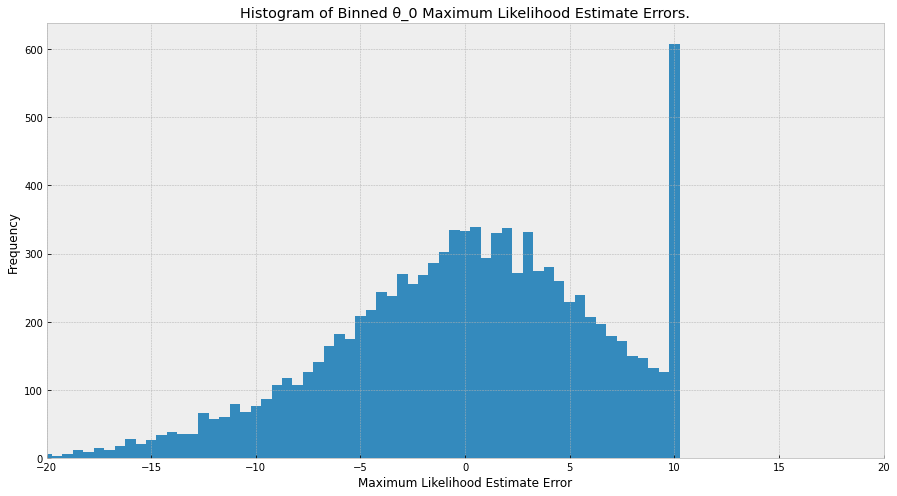

In [320]:
binned_mle_errors[0].plot.hist(bins=[(x-50.5)/2 for x in range(200)])
plt.xlim(-20, 20)
plt.title("Histogram of Binned θ_0 Maximum Likelihood Estimate Errors.")
plt.xlabel('Maximum Likelihood Estimate Error')
# plt.savefig("./thesis/mle_error.pdf")

Text(0.5, 0, 'Maximum Likelihood Estimate Error')

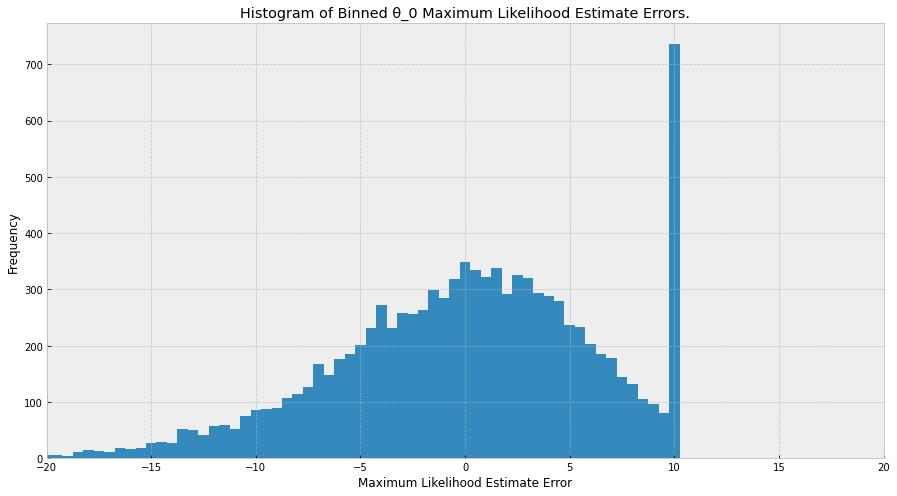

In [322]:
mle_errors[0].plot.hist(bins=[(x-50.5)/2 for x in range(200)])
plt.xlim(-20, 20)
plt.title("Histogram of Binned θ_0 Maximum Likelihood Estimate Errors.")
plt.xlabel('Maximum Likelihood Estimate Error')
# plt.savefig("./thesis/mle_error.pdf")